In [10]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

Let's use the same material definition as the existing pincell depletion example 

In [11]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water])

The geometry definition is going to be slightly different. Firstly, we want to bound the geometry in `z` assigning a pincell height. Secondly, we want to define a cell that contains a universe made of water and helium cells, separated by an interface, which we can initially set at $-59\ cm$ so that the initial condition of $k_{eff} \sim 1$ is satisfied. 

Filling the `msr` cell with a universe is the requirement to set up a geometrical reactivity controller, as we shall see in the `msr_pincell_reactivity_control` notebook.    

In [12]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
# set initial borated water level to -59 cm 
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
root = openmc.Universe(cells=[fuel, gap, clad, msr])
# Define overall geometry
geometry = openmc.Geometry(root)

In [13]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.IndependentSource(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

Let's plot the pincell. We can notice the initial interface between the borated water and helium cells.

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

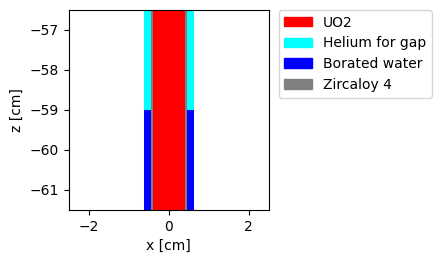

In [14]:
# Create plot
colors = {uo2:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
root.plot(width=(5, 5), origin=(0,0,-59), pixels=(200, 200), basis='xz', color_by='material', colors=colors, legend=True)

Let's now build and run a standard depletion calculation, increasing the thermal power to $100\ kW$. The results will be used as the reference to compare with MSR capabilities:

In [15]:
chain_file = '/home/lorenzo/ca_depletion_chains/chain_simple.xml'
uo2.volume = pi * fuel_or.r**2 * height
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 1.0e5  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Reading Pu239 from /home/lorenzo/nuclear_data/endfb80_hdf5/Pu239.h

In [16]:
res_ref = openmc.deplete.Results('depletion_results.h5')

Let's now introduce the concept of `TransferRates` at which some nuclides/elements get fed/removed to/from the depletable materials, as an additional proportional term to the Bateman equations. This concept assumes first-order removal and homegeneous distributions of the fission products (or elements to removed) throughout the material.

$ \frac{dn_i(t)}{dt} = \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\overline{\sigma_j\phi} - n_i \overline{\sigma_i \phi}}_\textbf{R}  + \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\lambda_{i\rightarrow j} + \lambda_{j\rightarrow i}n_i}_\textbf{D} - \underbrace{\epsilon_i \lambda_i n_i}_\textbf{T}$

Where $ \epsilon_i \lambda_i n_i $ is the removal term, and:

- $\epsilon_i$ is the removal efficiency 

- $\lambda_i$ is the removal rate coefficient for the continuous removal of the nuclide $i$ in ($s^{-1}$)

Another way to characterize $\lambda_i$ is through the concept of cycle time:

$T_{cyc,i} = \frac{1}{\lambda_i}$, as the time needed to process the removal elements at a specific volumetric rate. 

For simplicity, we can combine $\epsilon_i$ and $\lambda_i$ in one single parameter, that we can call again $\lambda_i$. Thus, setting a removal rate coefficient of, for example, $1\ (s^{-1})$ at $100\ \%$ efficiency is the same as setting $10\ (s^{-1})$ at $10\ \%$.

A new depletion matrix can be built as: 

$\frac{d\vec{n}}{dt} = \underbrace{(\textbf{R+D-T})}_\textbf{A}\vec{n} $, 

where:

- $\textbf{R}$ is the reaction rate term
- $\textbf{D}$ is the decay rate term 
- $\textbf{T}$ is the removal rate or transfer term 

That can be solved in a similar fashion. 

This capability has been added into OpenMC main code from version 0.14.0 and a more detailed description can be found in the user manual. 

Back to our case, let's set a removal rate of $0.1\ (s^{-1})$ for `Xenon` and re-run the the depletion model. 

To do it, we just need to call the `add_transfer_rate` method from the integrator instance, specifying the depletable material where to set transfe rates, the elements or nuclides to remove and a positive transfer rate (if a removal is what we want to set). In this case no `destination_material` attribute has been set, meaning that we will just remove elements without keeping track of them. 


In [17]:
# We need to re-instanciate the operator and the integrator 
op = openmc.deplete.CoupledOperator(model, chain_file)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_transfer_rate('UO2', ['Xe'], 0.1)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Reading Pu239 from /home/lorenzo/nuclear_data/endfb80_hdf5/Pu239.h

       52/1    0.99612    0.99609 +/- 0.00534
       53/1    1.03349    0.99696 +/- 0.00529
       54/1    1.00859    0.99723 +/- 0.00517
       55/1    1.01775    0.99768 +/- 0.00508
       56/1    0.92832    0.99617 +/- 0.00519
       57/1    0.93116    0.99479 +/- 0.00526
       58/1    1.02899    0.99550 +/- 0.00520
       59/1    0.99388    0.99547 +/- 0.00509
       60/1    1.03489    0.99626 +/- 0.00505
       61/1    0.97515    0.99584 +/- 0.00497
       62/1    0.98673    0.99567 +/- 0.00488
       63/1    0.93810    0.99458 +/- 0.00491
       64/1    1.03245    0.99528 +/- 0.00487
       65/1    0.98606    0.99512 +/- 0.00478
       66/1    1.00775    0.99534 +/- 0.00470
       67/1    0.96381    0.99479 +/- 0.00465
       68/1    1.13116    0.99714 +/- 0.00514
       69/1    0.99263    0.99706 +/- 0.00505
       70/1    1.06626    0.99822 +/- 0.00510
       71/1    0.94620    0.99736 +/- 0.00508
       72/1    0.97634    0.99703 +/- 0.00501
       73/1    1.04282    0.99775 

We can now compare the two cases:

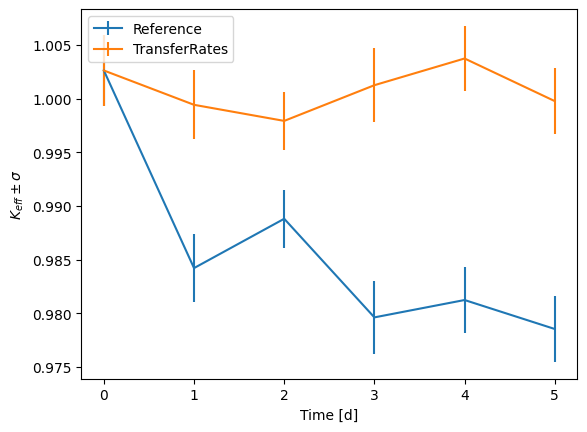

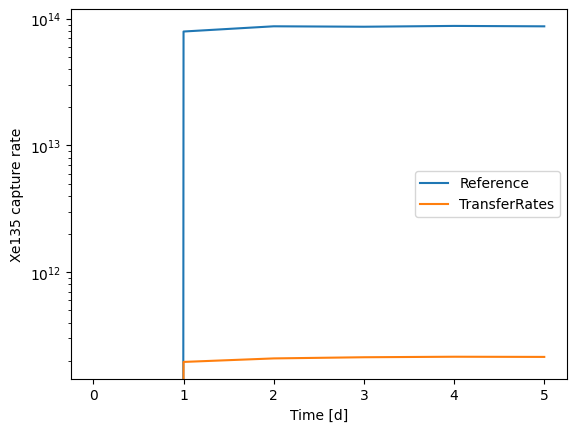

In [20]:
res_tr = openmc.deplete.Results('depletion_results.h5')
time, keff_ref = res_ref.get_keff(time_units='d')
_, keff_tr = res_tr.get_keff(time_units='d')
_, xe_ref = res_ref.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')
_, xe_tr = res_tr.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

# Generate plots
fig, ax = plt.subplots()
ax.errorbar(time, keff_ref[:, 0], keff_ref[:, 1], label="Reference")
ax.errorbar(time, keff_tr[:, 0], keff_ref[:, 1], label="TransferRates")
ax.set_xlabel("Time [d]")
ax.set_ylabel(r"$K_{eff}\pm \sigma$")
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, xe_ref, label="Reference")
ax.plot(time, xe_tr, label="TransferRates")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
ax.set_yscale('log')
plt.legend()
plt.show()



As expected, `keff` drops less dramatically in the `TransferRates` case, as an effect of the removal rate set for `Xe135`, as can also be verified by comparing the capture rates for the two cases. 